<a href="https://colab.research.google.com/github/engineerjkk/Interesting-Papers/blob/main/02.AlexNet(2012)/AlexNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Module and Load DataSet

In [1]:
import tensorflow as tf

In [2]:
import os

import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
import cv2

In [10]:
image = tf.cast(image, dtype=tf.float32)

In [28]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [49]:
from datetime import datetime
cfg={'image_size':224, 'channel_no':3, 'class_no':120, 'loss': 'cce', 'epochs': 50, 'batch_size':16, 
     'lr':0.0001, 'lr_scheduler':'step', 'resizemethod':'scale_crop', 'model':'googlenet'}
save_path='/content/drive/MyDrive/logs/improving_convnets/'+datetime.today().strftime('%Y-%m-%d-%H:%M:%S')


In [30]:
!pip install wandb -q
import wandb
wandb.login()
run = wandb.init(project='improving_convnets', config=cfg, entity='krenerd77')

     |████████████████████████████████| 1.7 MB 28.9 MB/s 
     |████████████████████████████████| 97 kB 5.9 MB/s 
     |████████████████████████████████| 139 kB 53.8 MB/s 
     |████████████████████████████████| 180 kB 57.5 MB/s 
     |████████████████████████████████| 63 kB 1.7 MB/s 


<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter: ··········


wandb: ERROR API key must be 40 characters long, yours was 26


<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter: ··········


In [31]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import cv2
from tqdm import tqdm
import tensorflow_datasets as tfds

In [32]:
ds, info=tfds.load('stanford_dogs',data_dir='/content/drive/MyDrive/data/stanford_dogs', with_info=True)

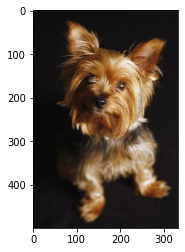

tf.Tensor(36, shape=(), dtype=int64)


In [128]:
for x in ds['train'].take(1):
  plt.imshow(x['image'])
  plt.show()
  print(x['label'])

In [129]:
def f_resize_image(image, label, resize_target=224, preserve_ratio=True):
  height, width, _ = np.shape(image)
  epsilon=1e-08
  if preserve_ratio:
    if height < width:
      size_ratio = resize_target / height + epsilon
    else:
      size_ratio = resize_target / width + epsilon
    resize_shape = (int(width * size_ratio), int(height * size_ratio))  # width and height in cv2 are opposite to np.shape()
  else:
    resize_shape = (resize_target, resize_target)
  return cv2.resize(image.numpy(), resize_shape), label

def f_crop_image(image, label, resize_target=224):
  height, width, _ = np.shape(image)

  crop_x = (width - resize_target) // 2
  crop_y = (height - resize_target) // 2
  return image[crop_y: crop_y + resize_target, crop_x: crop_x + resize_target, :], label

def parse_data(data):
    image, label = data['image'], data['label']
    image = image / 255

    return (image, label)
    

In [130]:
# Load TRAIN dataset
train_dataset=ds['train']
train_dataset=train_dataset.map(parse_data, num_parallel_calls=tf.data.experimental.AUTOTUNE)
if cfg['resizemethod']=='scale_crop':
  train_dataset=train_dataset.map(lambda x, y: tf.py_function(f_resize_image, inp=[x, y, cfg['image_size']], Tout=[tf.float32, tf.int64]))
  train_dataset=train_dataset.map(lambda x, y: tf.py_function(f_crop_image, inp=[x, y, cfg['image_size']], Tout=[tf.float32, tf.int64]))
elif cfg['resizemethod']=='resize':
  train_dataset=train_dataset.map(lambda x, y: tf.py_function(f_resize_image, inp=[x, y, cfg['image_size'], False], Tout=[tf.float32, tf.int64]))
# Calculate length of datast and steps per epoch
data_len=tqdm(train_dataset, position=0, leave=True).total
step_per_epoch = data_len // cfg['batch_size'] + (data_len % cfg['batch_size'] > 0)

train_dataset=train_dataset.batch(cfg['batch_size']).repeat()

# Load TEST dataset
test_dataset=ds['test']
test_dataset=test_dataset.map(parse_data, num_parallel_calls=tf.data.experimental.AUTOTUNE)
if cfg['resizemethod']=='scale_crop':
  test_dataset=test_dataset.map(lambda x, y: tf.py_function(f_resize_image, inp=[x, y, cfg['image_size']], Tout=[tf.float32, tf.int64]))
  test_dataset=test_dataset.map(lambda x, y: tf.py_function(f_crop_image, inp=[x, y, cfg['image_size']], Tout=[tf.float32, tf.int64]))
elif cfg['resizemethod']=='resize':
  test_dataset=test_dataset.map(lambda x, y: tf.py_function(f_resize_image, inp=[x, y, cfg['image_size'], False], Tout=[tf.float32, tf.int64]))
test_dataset=test_dataset.batch(cfg['batch_size'])

  0%|          | 0/12000 [00:00<?, ?it/s]


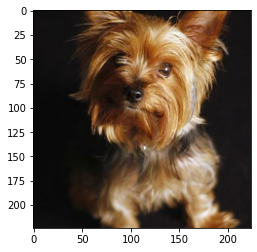

tf.Tensor(36, shape=(), dtype=int64)


In [131]:
for x in train_dataset.take(1):
  plt.imshow(x[0][0])
  plt.show()
  print(x[1][0])

In [132]:
x[0][0].shape

TensorShape([224, 224, 3])

In [133]:
image = x[0][0][tf.newaxis, ...]

In [134]:
image.shape

TensorShape([1, 224, 224, 3])

# 1st Convolutional Layer

In [135]:
layer = tf.keras.layers.Conv2D(filters=96, input_shape=(224,224,3), kernel_size=(11,11),strides=(4,4), padding='valid')
output = layer(image)

In [136]:
import numpy as np
np.min(image),np.max(image)

(0.0, 1.0)

In [137]:
np.min(output),np.max(output)

(-0.5648269, 0.5401235)

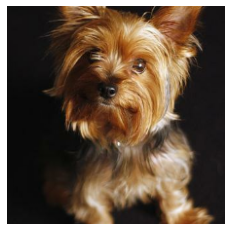

In [138]:
#plt.title(image[0,:,:,:].shape)
plt.axis('off')
plt.imshow(image[0,:,:,:])

InvalidArgumentError: ignored

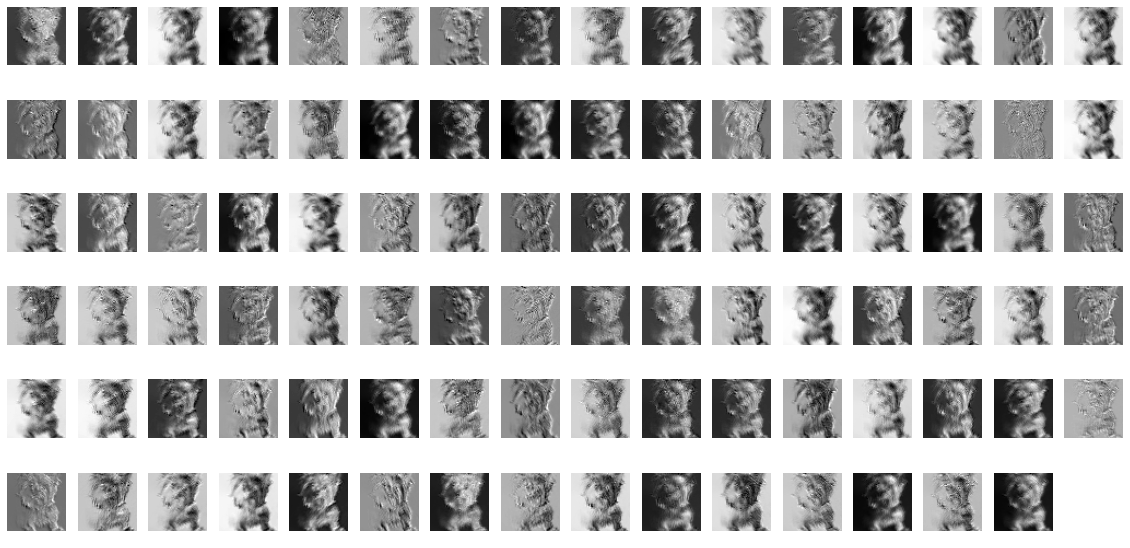

In [139]:
plt.figure(figsize=(20, 10))
for i in range (1,97):
  plt.subplot(6,16,i)
  plt.axis('off')
  plt.imshow(output[0,:,:,i],'gray')

In [140]:
image.shape

TensorShape([1, 224, 224, 3])

In [141]:
output.shape

TensorShape([1, 54, 54, 96])

In [142]:
weight=layer.get_weights()
len(weight)

2

In [143]:
weight[0].shape,weight[1].shape

((11, 11, 3, 96), (96,))

In [144]:
weight[0].shape


(11, 11, 3, 96)

In [145]:
layer=tf.keras.layers.BatchNormalization()
output=layer(output)

In [146]:
layer=tf.keras.layers.Activation('relu')
output=layer(output)

In [147]:
layer=tf.keras.layers.MaxPooling2D(pool_size=(2,2),strides=(2,2),padding='same')
output=layer(output)

InvalidArgumentError: ignored

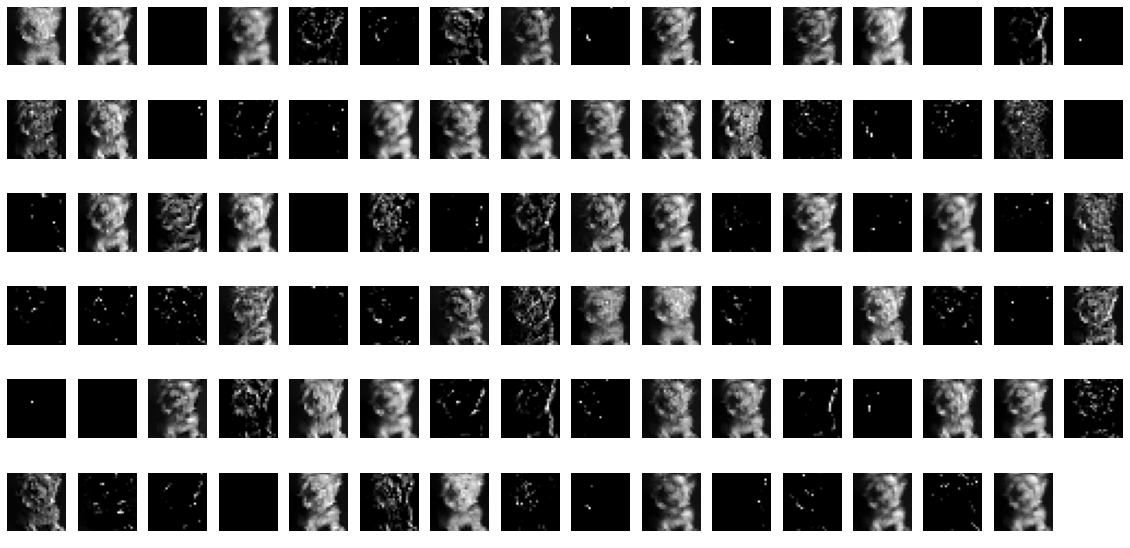

In [148]:
plt.figure(figsize=(20, 10))
for i in range (1,97):
  plt.subplot(6,16,i)
  plt.axis('off')
  plt.imshow(output[0,:,:,i],'gray')

# 2nd Convolutional Layer

In [149]:
layer = tf.keras.layers.Conv2D(filters=256, kernel_size=(5,5),strides=(1,1), padding='same')
output = layer(output)

InvalidArgumentError: ignored

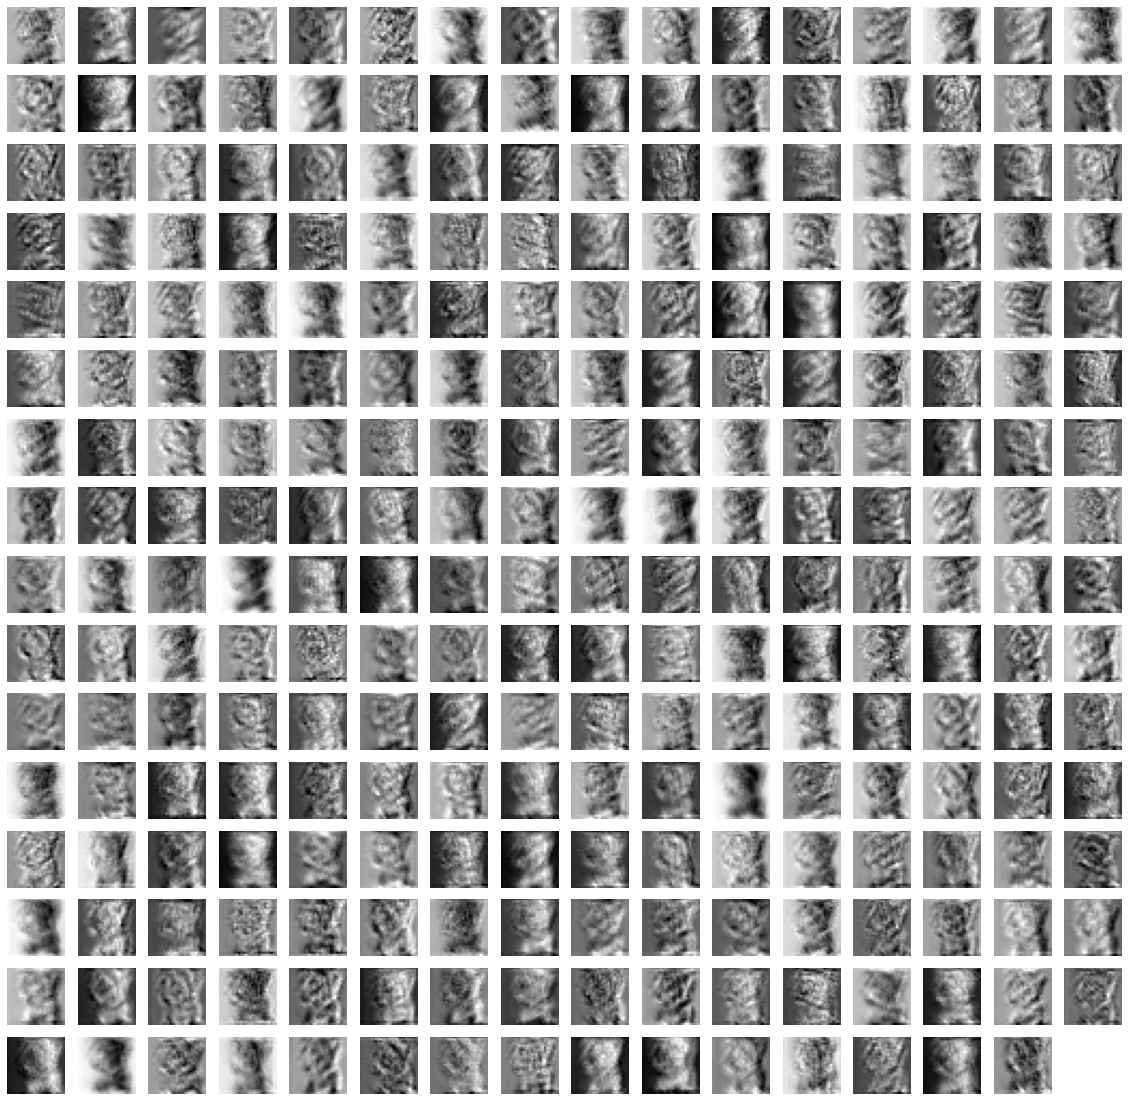

In [150]:
plt.figure(figsize=(20, 20))
for i in range (1,257):
  plt.subplot(16,16,i)
  plt.axis('off')
  plt.imshow(output[0,:,:,i],'gray')

In [151]:
weight=layer.get_weights()
len(weight)

2

In [152]:
weight[0].shape

(5, 5, 96, 256)

IndexError: ignored

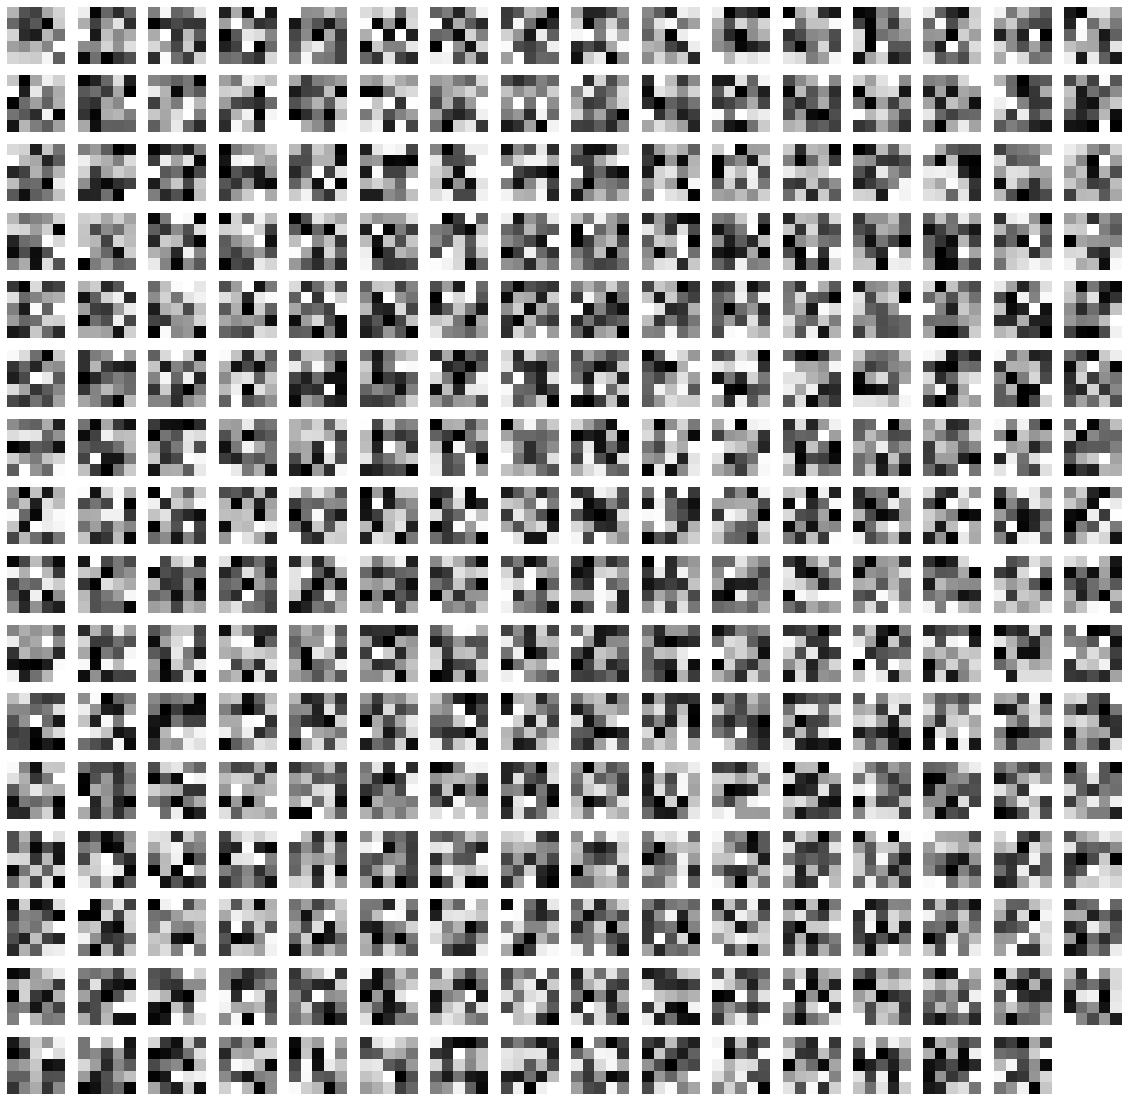

In [153]:
plt.figure(figsize=(20, 20))
for i in range (1,257):
  plt.subplot(16,16,i)
  plt.axis('off')
  plt.imshow(weight[0][:,:,0,i],'gray')

In [154]:
layer=tf.keras.layers.BatchNormalization()
output=layer(output)

In [155]:
layer=tf.keras.layers.Activation('relu')
output=layer(output)

In [156]:
layer=tf.keras.layers.MaxPooling2D(pool_size=(2,2),strides=(2,2),padding='same')
output=layer(output)

InvalidArgumentError: ignored

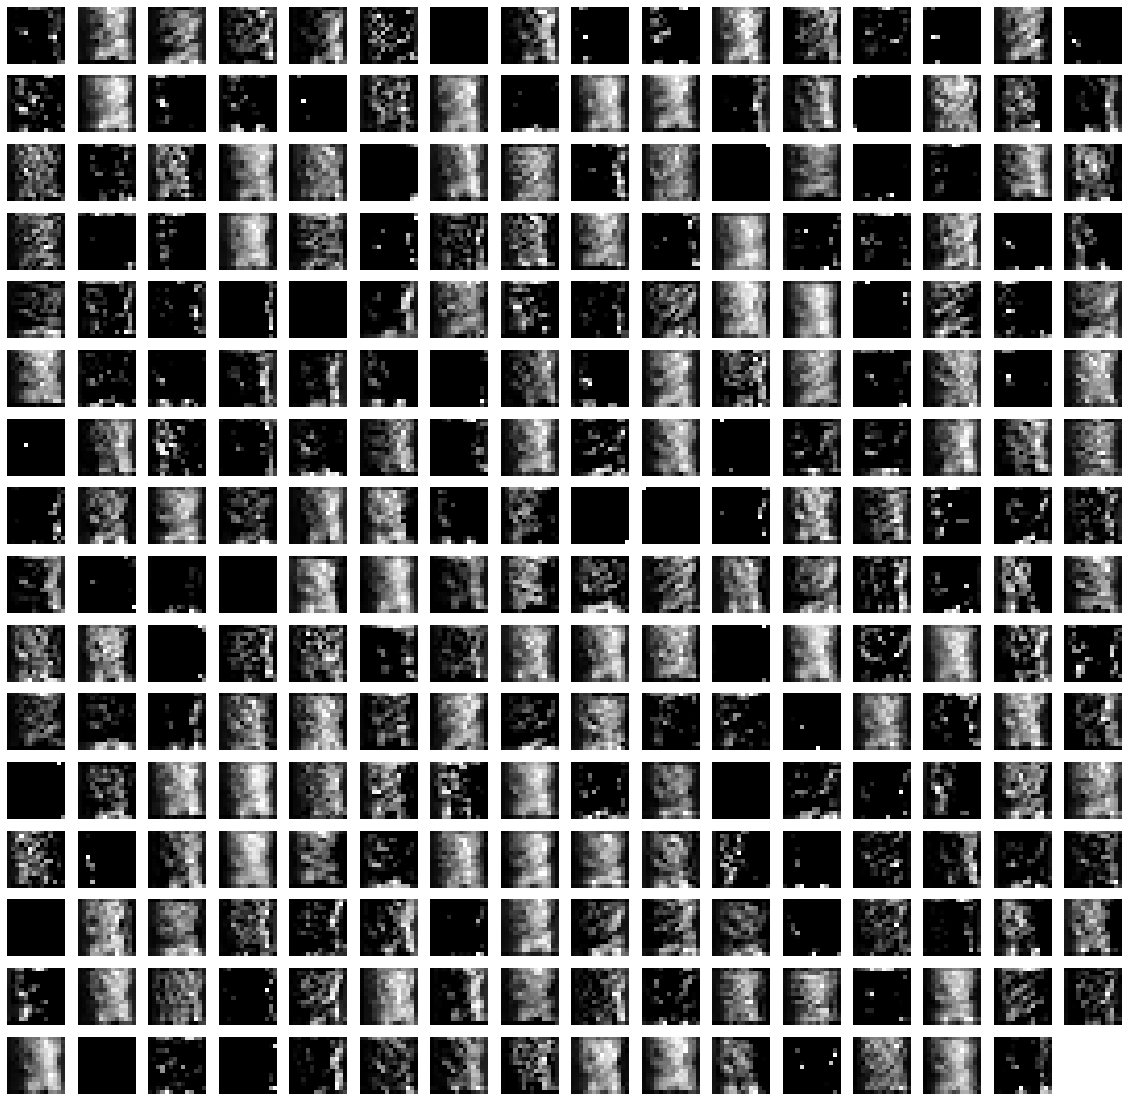

In [157]:
plt.figure(figsize=(20, 20))
for i in range (1,257):
  plt.subplot(16,16,i)
  plt.axis('off')
  plt.imshow(output[0,:,:,i],'gray')

# 3rd Convolutional Layer

In [158]:
layer = tf.keras.layers.Conv2D(filters=384, kernel_size=(3,3),strides=(1,1), padding='same')
output = layer(output)

InvalidArgumentError: ignored

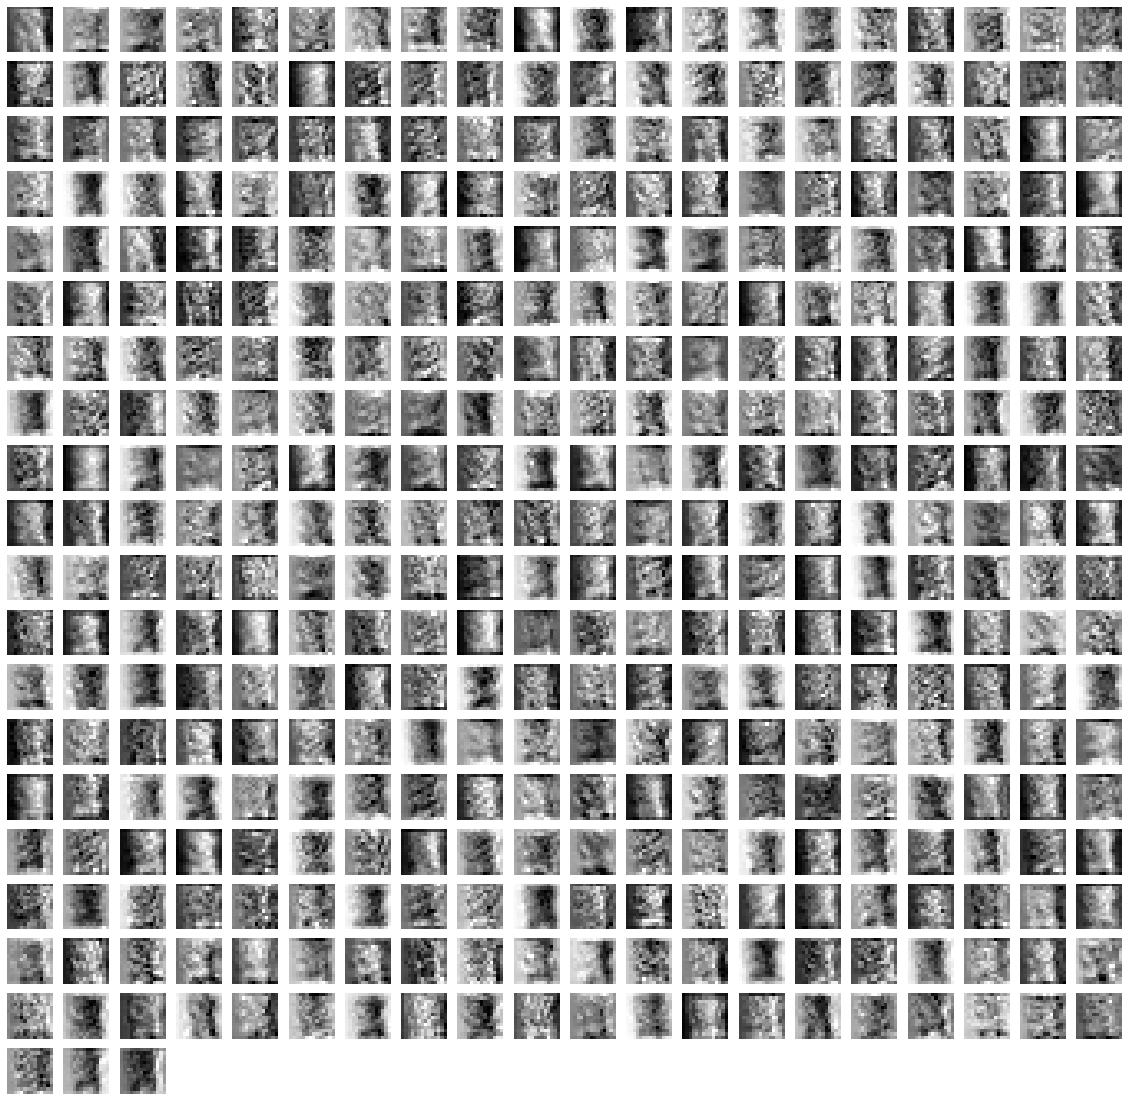

In [159]:
plt.figure(figsize=(20, 20))
for i in range (1,385):
  plt.subplot(20,20,i)
  plt.axis('off')
  plt.imshow(output[0,:,:,i],'gray')

In [160]:
layer=tf.keras.layers.BatchNormalization()
output=layer(output)

In [161]:
layer=tf.keras.layers.Activation('relu')
output=layer(output)

# 4th Convolutional Layer

In [162]:
layer = tf.keras.layers.Conv2D(filters=384, kernel_size=(3,3),strides=(1,1), padding='same')
output = layer(output)

InvalidArgumentError: ignored

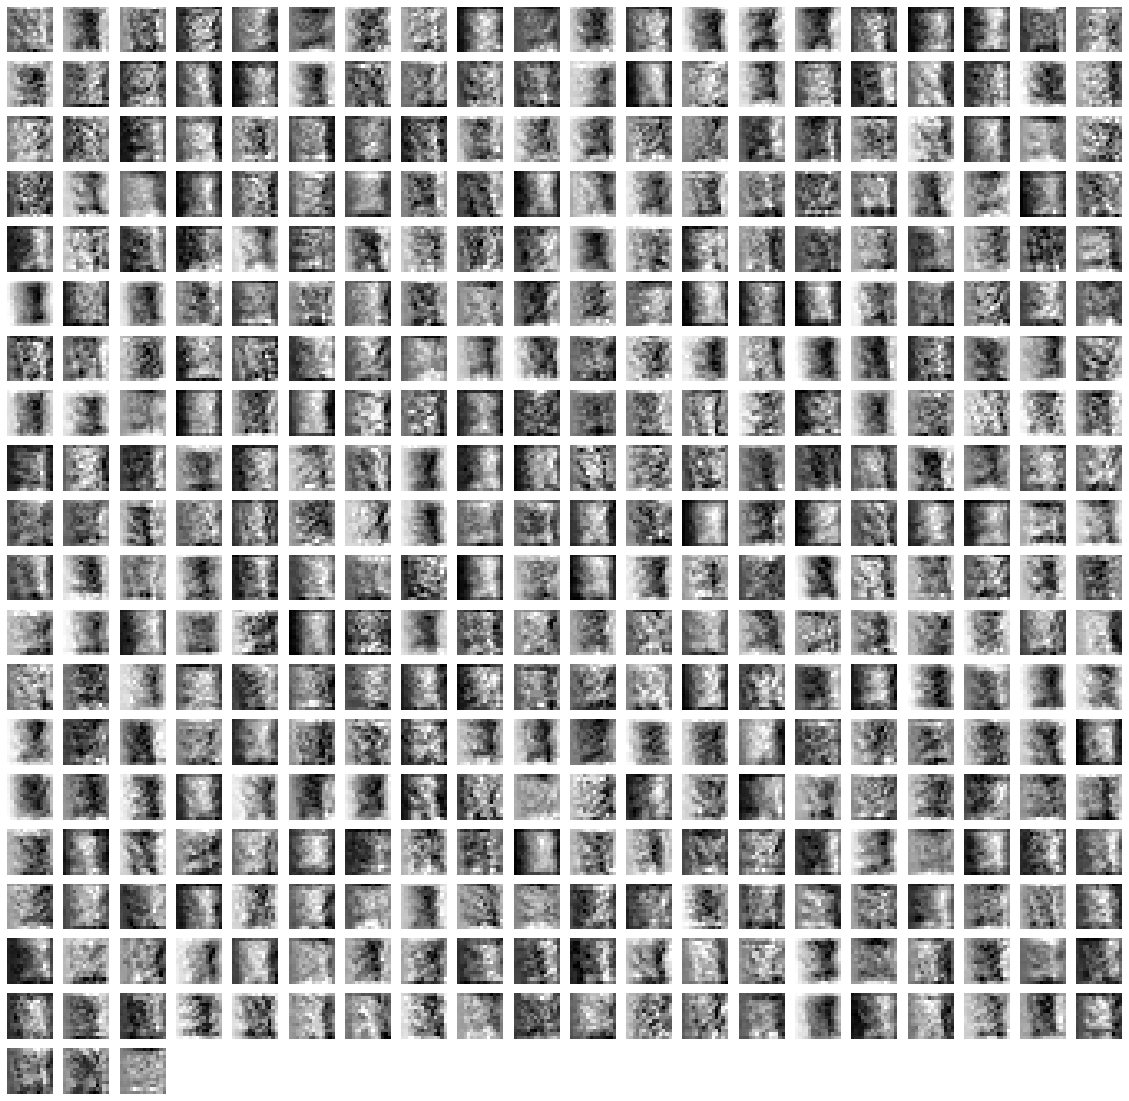

In [163]:
plt.figure(figsize=(20, 20))
for i in range (1,385):
  plt.subplot(20,20,i)
  plt.axis('off')
  plt.imshow(output[0,:,:,i],'gray')

In [164]:
layer=tf.keras.layers.BatchNormalization()
output=layer(output)

In [165]:
layer=tf.keras.layers.Activation('relu')
output=layer(output)

# 5th Convolutional Layer

In [166]:
layer = tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3),strides=(1,1), padding='same')
output = layer(output)

InvalidArgumentError: ignored

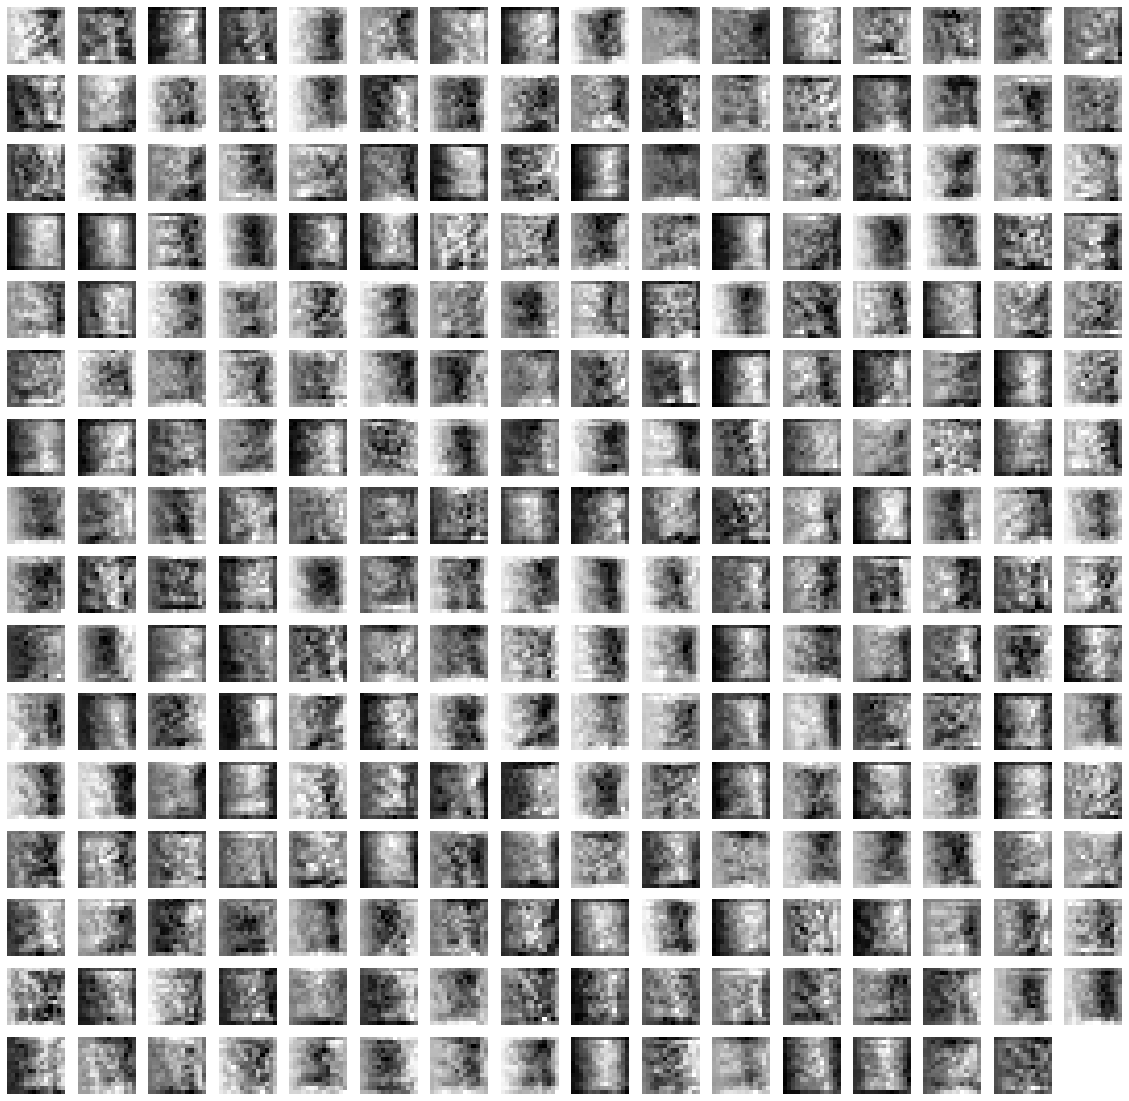

In [167]:
plt.figure(figsize=(20, 20))
for i in range (1,257):
  plt.subplot(16,16,i)
  plt.axis('off')
  plt.imshow(output[0,:,:,i],'gray')

In [168]:
layer=tf.keras.layers.BatchNormalization()
output=layer(output)

In [169]:
layer=tf.keras.layers.Activation('relu')
output=layer(output)

# Classifier

In [172]:
layer=tf.keras.layers.Flatten()
output=layer(output)

In [173]:
output.shape

TensorShape([1, 50176])

(array([3.6046e+04, 6.0700e+03, 3.3790e+03, 1.9820e+03, 1.2310e+03,
        7.9000e+02, 4.3900e+02, 1.7100e+02, 5.8000e+01, 1.0000e+01]),
 array([0.        , 0.00960222, 0.01920443, 0.02880665, 0.03840886,
        0.04801108, 0.05761329, 0.06721551, 0.07681773, 0.08641994,
        0.09602216], dtype=float32),
 <a list of 10 Patch objects>)

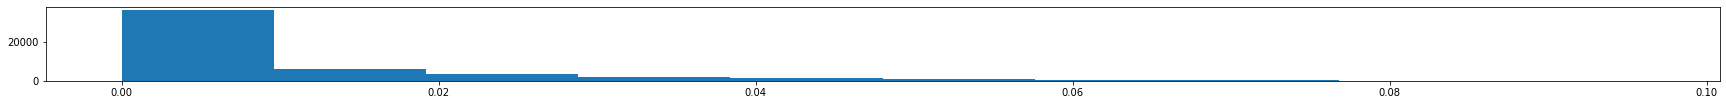

In [176]:
plt.figure(figsize=(30, 3))
plt.subplot(211)
plt.hist(output.numpy().ravel())

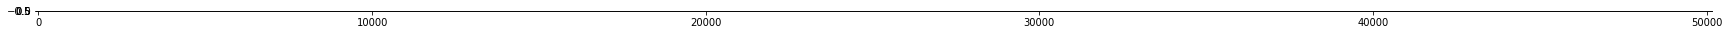

In [182]:
plt.figure(figsize=(30,100))
plt.imshow(output[:,:50176],'gray')
plt.show()

# 1st Fully Connected Layer

In [183]:
layer=tf.keras.layers.Dense(4096,input_shape=(32,32,3,))
output=layer(output)

In [184]:
layer=tf.keras.layers.BatchNormalization()
output=layer(output)

In [185]:
layer=tf.keras.layers.Activation('relu')
output=layer(output)

In [186]:
layer=tf.keras.layers.Dropout(0.4)
output=layer(output)

In [187]:
output.shape

TensorShape([1, 4096])

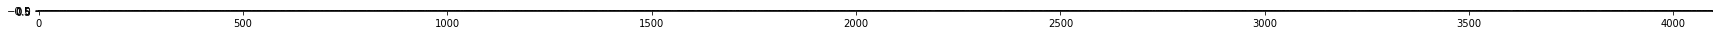

In [190]:
plt.figure(figsize=(30,100))
plt.imshow(output[:,:4096],'gray')
plt.show()

# 2nd Fully Connected Layer

In [191]:
layer=tf.keras.layers.Dense(4096)
output=layer(output)

In [192]:
layer=tf.keras.layers.BatchNormalization()
output=layer(output)

In [193]:
layer=tf.keras.layers.Activation('relu')
output=layer(output)

In [194]:
layer=tf.keras.layers.Dropout(0.4)
output=layer(output)

In [ ]:
plt.figure(figsize=(30,100))
plt.imshow(output[:,:4096],'gray')
plt.show()

# 3rd Fully Connected Layer

In [195]:
layer=tf.keras.layers.Dense(1000)
output=layer(output)

In [196]:
layer=tf.keras.layers.BatchNormalization()
output=layer(output)

In [197]:
layer=tf.keras.layers.Activation('relu')
output=layer(output)

In [198]:
layer=tf.keras.layers.Dropout(0.4)
output=layer(output)

In [199]:
output.shape

TensorShape([1, 1000])

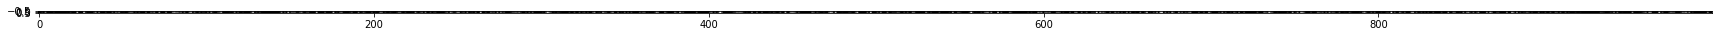

In [200]:
plt.figure(figsize=(30,100))
plt.imshow(output[:,:1000],'gray')
plt.show()

# Output Layer

In [201]:
layer=tf.keras.layers.Dense(1000)
output=layer(output)

In [202]:
layer=tf.keras.layers.BatchNormalization()
output=layer(output)

In [203]:
layer=tf.keras.layers.Activation('softmax')
output=layer(output)

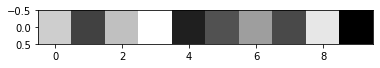

In [204]:
plt.imshow(output[:,:10],'gray')
plt.show()

# Model Summary

In [206]:
output.summary()

AttributeError: ignored

In [208]:
def build_model(model_type, cfg):
  if model_type=='alexnet':
    model=alexnet(cfg)
  return model

In [212]:
model=build_model(alexnet, cfg)

NameError: ignored

* 이제 다시 model sequence로 정리해서 summary를 보고, 이것을 학습시킬것 그 후에 지금까지 했던 sequence feature를 다시 추출하는 과정을 보이도록하자!